# Block 5 Exercise 2: Predicting the fare of taxi rides
Using the NY Taxi data set (see Use Case Block I) and the use case from the lecture...

In [1]:
import pandas as pd
import numpy as np
import folium

In [2]:
# we load the data we have saved after wrangling and pre-processing in block I
X=pd.read_csv('../../DATA/train_cleaned.csv')
drop_columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','key','pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']
X=X.drop(drop_columns,axis=1)
X=pd.get_dummies(X)# one hot coding
#generate labels
y=X['fare_amount']
X=X.drop(['fare_amount'],axis=1)

In [3]:
# a quick look at the data
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,...,pickup_borough_manhattan,pickup_borough_others,pickup_borough_queens,pickup_borough_staten_island,dropoff_borough_bronx,dropoff_borough_brooklyn,dropoff_borough_manhattan,dropoff_borough_others,dropoff_borough_queens,dropoff_borough_staten_island
0,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,...,0,0,1,0,0,0,0,0,1,0
1,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,...,1,0,0,0,0,0,1,0,0,0
2,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,...,1,0,0,0,0,0,1,0,0,0
3,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,...,1,0,0,0,0,0,1,0,0,0
4,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,...,1,0,0,0,0,0,1,0,0,0


In [4]:
y.head()

0     4.5
1    16.9
2     5.7
3     7.7
4     5.3
Name: fare_amount, dtype: float64

### E 2.1 Split data into train and test data
* use data from 2009-1014 for training and 2015 for evaluation


In [10]:
X_train = X[X.pickup_year<=2014]
y_train = y[X.pickup_year<=2014]
X_test=X[X.pickup_year==2015]
y_test=y[X.pickup_year==2015]

print(X_train.shape)
print(X_test.shape)

(372110, 31)
(27890, 31)


### E 2.2 Train a Random Forest Regression Model
* train model using [RF regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
* optimize the model parameters (#trees, depth, vars per split, ...) and evaluate the [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) on train and test data
* Analyze the model error: are there typical settings where the model fails?

#### Train model

In [11]:
%%time
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=20,n_estimators=100, n_jobs = -1, random_state=0)
regr.fit(X_train, y_train)

Wall time: 4min 38s


RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=0)

#### Parameter optimization and evaluation

##### Befor

In [12]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,regr.predict(X_test))

21.351594294602663

##### After

In [17]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[8,10,20,30], 'n_estimators':[2,10,20,40]}
regr = RandomForestRegressor(n_jobs=-1, random_state=0)
clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)

mean_squared_error(y_test,clf.predict(X_test))

KeyboardInterrupt: 

##### Analyze

In [36]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score with train data: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.475 (std: 0.010)
Parameters: {'max_depth': 20, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.470 (std: 0.008)
Parameters: {'max_depth': 20, 'n_estimators': 40}

Model with rank: 3
Mean validation score: 0.467 (std: 0.014)
Parameters: {'max_depth': 20, 'n_estimators': 20}



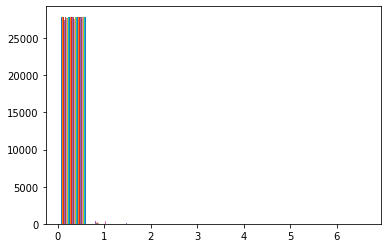

In [37]:
import matplotlib.pyplot as plt
difference = np.abs(y_test-clf.predict(X_test))
hist = plt.hist(difference,bins=10)

Mit den gefundenen Parametern gibt es nur wenige Werte die sehr hohe Differenzen aufweisen.